In [173]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings
import numpy as np
import requests
from io import StringIO

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [174]:
# Define the base path and URLs as per your config file
BASE_CDN_PATH = "https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com"
TRACKING_DATA_URL_TEMPLATE = BASE_CDN_PATH + "/raw/tracking_data/tracking_week_{week}.csv"
PLAYS_URL = BASE_CDN_PATH + "/raw/plays.csv"
GAMES_URL = BASE_CDN_PATH + "/raw/games.csv"
PLAYERS_URL = BASE_CDN_PATH + "/raw/players.csv"
COLORS_URL = BASE_CDN_PATH + "/raw/colors.csv"
TACKLES_URL = BASE_CDN_PATH + "/raw/tackles.csv"

# Replace 'week' with the actual week number you want to download
week_number = 1
TRACKING_DATA_URL = TRACKING_DATA_URL_TEMPLATE.format(week=week_number)

# Define a function to download and return a DataFrame
def download_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Assuming the data is in CSV format
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to download data from {url}")
        return None


# Download the data
tracking_data = download_data(TRACKING_DATA_URL)
plays_data = download_data(PLAYS_URL)
players_data = download_data(PLAYERS_URL)
colors_data = download_data(COLORS_URL)
tackles_data = download_data(TACKLES_URL)
games_data = download_data(GAMES_URL) 

In [175]:
# Example of analysis: Display the first few rows of each DataFrame
print(tracking_data.info())
print(plays_data.info())
print(players_data.info())
print(colors_data.info())
print(tackles_data.info())
print(games_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407439 entries, 0 to 1407438
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   gameId         1407439 non-null  int64  
 1   playId         1407439 non-null  int64  
 2   nflId          1346246 non-null  float64
 3   displayName    1407439 non-null  object 
 4   frameId        1407439 non-null  int64  
 5   time           1407439 non-null  object 
 6   jerseyNumber   1346246 non-null  float64
 7   club           1407439 non-null  object 
 8   playDirection  1407439 non-null  object 
 9   x              1407439 non-null  float64
 10  y              1407439 non-null  float64
 11  s              1407439 non-null  float64
 12  a              1407439 non-null  float64
 13  dis            1407439 non-null  float64
 14  o              1346397 non-null  float64
 15  dir            1346397 non-null  float64
 16  event          130268 non-null   object 
dtypes: float

In [176]:
df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_1_completions_only_run2.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# # Loop through weeks 2 to 9
# for week in range(1, 10):
#     # Construct file path for the current week
#     file_path = f'/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_{week}.csv'
    
#     # Read the data
#     week_df = pd.read_csv(file_path)
    
#     # Remove any unnamed columns
#     week_df = week_df.loc[:, ~week_df.columns.str.contains('^Unnamed')]
    
#     # Append to the original DataFrame
#     df = pd.concat([df, week_df], ignore_index=True)


In [194]:
df.columns

Index(['nflId', 'frechet_distance', 'play_id', 'game_id', 'week_num',
       'displayName', 'position', 'gameId', 'playId', 'passResult',
       'expectedPointsAdded', 'defensiveTeam', 'tackle', 'assist',
       'forcedFumble', 'pff_missedTackle'],
      dtype='object')

In [177]:
# For run2
frechet_distances_run2 = df['frechet_distance']

# For run1 (week 1)
file_path_run1_week1 = '/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_1.csv'
df_run1_week1 = pd.read_csv(file_path_run1_week1)
df_run1_week1 = df_run1_week1.loc[:, ~df_run1_week1.columns.str.contains('^Unnamed')]
# Assuming 'pass_result' is the column with pass results and 'C' stands for a completed pass
df_run1_week1_complete = df_run1_week1[df_run1_week1['passResult'] == 'C']
frechet_distances_run1_week1 = df_run1_week1_complete['frechet_distance']

In [178]:
df_run1_week1.columns

Index(['nflId', 'frechet_distance', 'play_id', 'game_id', 'week_num',
       'displayName', 'position', 'gameId', 'playId', 'passResult',
       'expectedPointsAdded', 'defensiveTeam'],
      dtype='object')

In [179]:
stats_run2 = frechet_distances_run2.describe()
stats_run1_week1 = frechet_distances_run1_week1.describe()

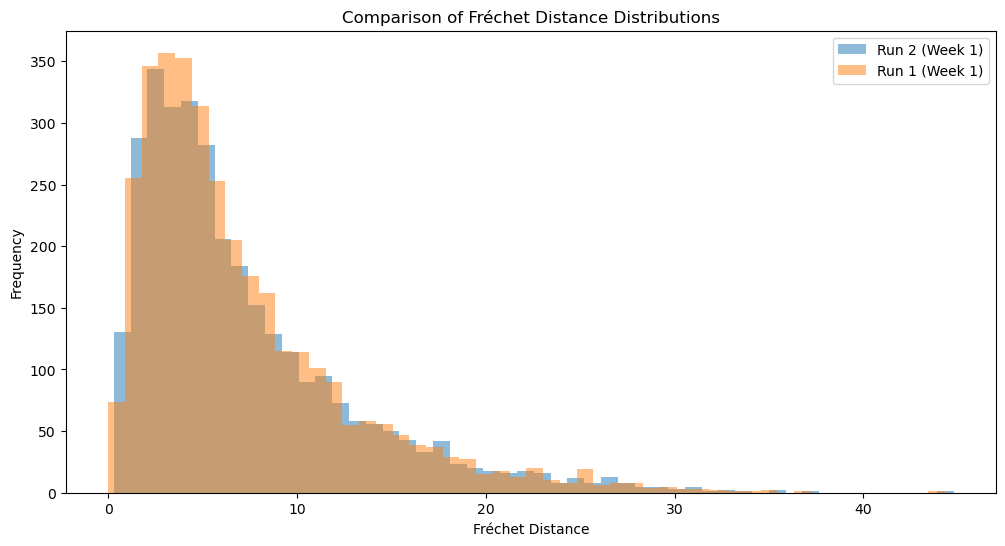

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(frechet_distances_run2, bins=50, alpha=0.5, label='Run 2 (Week 1)')
plt.hist(frechet_distances_run1_week1, bins=50, alpha=0.5, label='Run 1 (Week 1)')
plt.xlabel('Fréchet Distance')
plt.ylabel('Frequency')
plt.title('Comparison of Fréchet Distance Distributions')
plt.legend()
plt.show()


In [181]:
from scipy.stats import ks_2samp

ks_statistic, ks_p_value = ks_2samp(frechet_distances_run2, frechet_distances_run1_week1)



In [182]:
from scipy.stats import ks_2samp

ks_statistic, ks_p_value = ks_2samp(frechet_distances_run2, frechet_distances_run1_week1)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")


KS Statistic: 0.011267136731114192
P-value: 0.982928841012973


In [183]:
#sanity check
plays_per_game = df.groupby('game_id')['play_id'].nunique()

# Calculating the average number of plays per game
average_plays_per_game = plays_per_game.mean()
average_plays_per_game

42.666666666666664

In [184]:
# Merge the DataFrames on 'playId' and 'nflId'
merged_df = pd.merge(df, tackles_data, left_on=['playId', 'nflId','gameId'], right_on=['playId', 'nflId','gameId'], how='left')

In [185]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                3186 non-null   float64
 1   frechet_distance     3186 non-null   float64
 2   play_id              3186 non-null   int64  
 3   game_id              3186 non-null   int64  
 4   week_num             3186 non-null   int64  
 5   displayName          3186 non-null   object 
 6   position             3186 non-null   object 
 7   gameId               3186 non-null   int64  
 8   playId               3186 non-null   int64  
 9   passResult           3170 non-null   object 
 10  expectedPointsAdded  3186 non-null   float64
 11  defensiveTeam        3186 non-null   object 
 12  tackle               519 non-null    float64
 13  assist               519 non-null    float64
 14  forcedFumble         519 non-null    float64
 15  pff_missedTackle     519 non-null    f

In [186]:
# Replace NaN in 'passResult' with 'R' (for run plays)
df['passResult'].fillna('R', inplace=True)

# Step 2: Check for Duplicates
# Ensure no duplicates based on game, play, and nflId
if df.duplicated(subset=['game_id', 'play_id', 'nflId']).any():
    print("There are duplicates based on game, play, and nflId.")
    # Optional: Remove duplicates
    df = df.drop_duplicates(subset=['game', 'play', 'nflId'])

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                3186 non-null   float64
 1   frechet_distance     3186 non-null   float64
 2   play_id              3186 non-null   int64  
 3   game_id              3186 non-null   int64  
 4   week_num             3186 non-null   int64  
 5   displayName          3186 non-null   object 
 6   position             3186 non-null   object 
 7   gameId               3186 non-null   int64  
 8   playId               3186 non-null   int64  
 9   passResult           3186 non-null   object 
 10  expectedPointsAdded  3186 non-null   float64
 11  defensiveTeam        3186 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 298.8+ KB


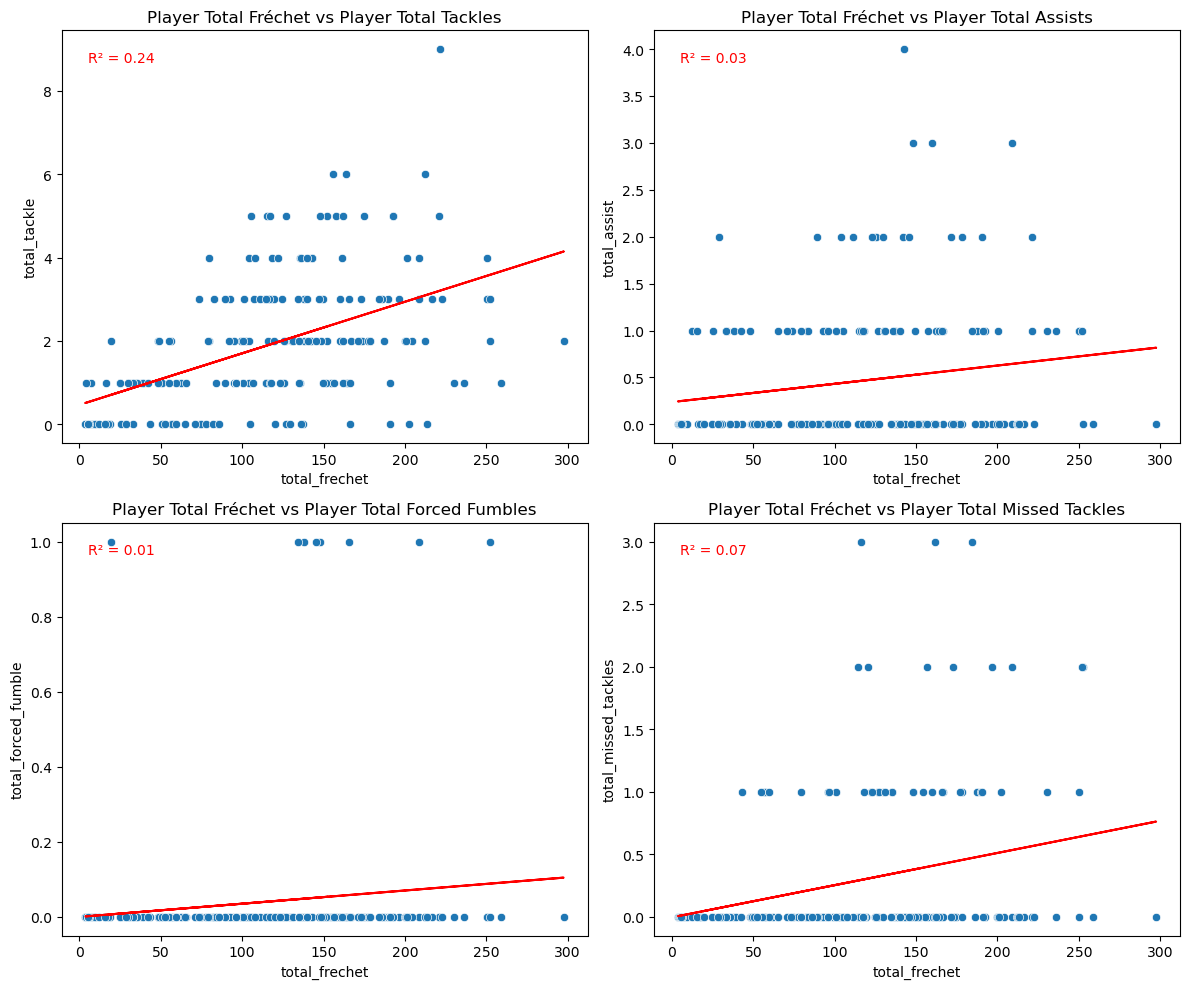

In [188]:
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt

df = merged_df
# Fill NaN values with zeros for tackle-related columns
tackle_cols = ['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']
df[tackle_cols] = df[tackle_cols].fillna(0)

# Aggregate at the player level
player_level_data = df.groupby(['nflId', 'displayName']).agg(
    total_frechet=('frechet_distance', 'sum'),
    total_tackle=('tackle', 'sum'),
    total_assist=('assist', 'sum'),
    total_forced_fumble=('forcedFumble', 'sum'),
    total_missed_tackles=('pff_missedTackle', 'sum'),
).reset_index()

# Define a function to create scatter plots with trend lines
def create_scatter_plot(x, y, data, ax, title):
    sns.scatterplot(x=x, y=y, data=data, ax=ax)
    ax.set_title(title)
    slope, intercept, r_value, p_value, std_err = linregress(data[x], data[y])
    ax.plot(data[x], intercept + slope*data[x], color='red')  # Trend line
    ax.text(0.05, 0.95, f'R\u00b2 = {r_value**2:.2f}', transform=ax.transAxes,
            color='red', verticalalignment='top')

# Create scatter plots for player-level data
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
create_scatter_plot('total_frechet', 'total_tackle', player_level_data, axs[0, 0], 'Player Total Fréchet vs Player Total Tackles')
create_scatter_plot('total_frechet', 'total_assist', player_level_data, axs[0, 1], 'Player Total Fréchet vs Player Total Assists')
create_scatter_plot('total_frechet', 'total_forced_fumble', player_level_data, axs[1, 0], 'Player Total Fréchet vs Player Total Forced Fumbles')
create_scatter_plot('total_frechet', 'total_missed_tackles', player_level_data, axs[1, 1], 'Player Total Fréchet vs Player Total Missed Tackles')
plt.tight_layout()
plt.show()

# Aggregate at the team level for both pass and run plays
team_level_data = df.groupby(['defensiveTeam', 'passResult']).agg(
    avg_frechet_per_play=('frechet_distance', lambda x: x.sum() / x.count()),
    total_tackle=('tackle', 'sum'),
    total_assist=('assist', 'sum'),
    total_forced_fumble=('forcedFumble', 'sum'),
    total_missed_tackles=('pff_missedTackle', 'sum'),
).reset_index()


High correlation here because the players are traviling farther and farther away from the frechet distance when a secondary player makes a tackle. 

In [189]:
# Fill NaN values with zeros for tackle-related columns
tackle_cols = ['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']
df[tackle_cols] = df[tackle_cols].fillna(0)

In [190]:
# Aggregate at the team level
team_level_agg = df.groupby('defensiveTeam').agg(
    sum_frechet=('frechet_distance', 'sum'),
    avg_frechet=('frechet_distance', 'mean'),
    sum_tackle=('tackle', 'sum'),
    avg_tackle=('tackle', 'mean'),
    sum_assist=('assist', 'sum'),
    avg_assist=('assist', 'mean'),
    sum_forced_fumble=('forcedFumble', 'sum'),
    avg_forced_fumble=('forcedFumble', 'mean'),
    sum_missed_tackles=('pff_missedTackle', 'sum'),
    avg_missed_tackles=('pff_missedTackle', 'mean')
).reset_index()


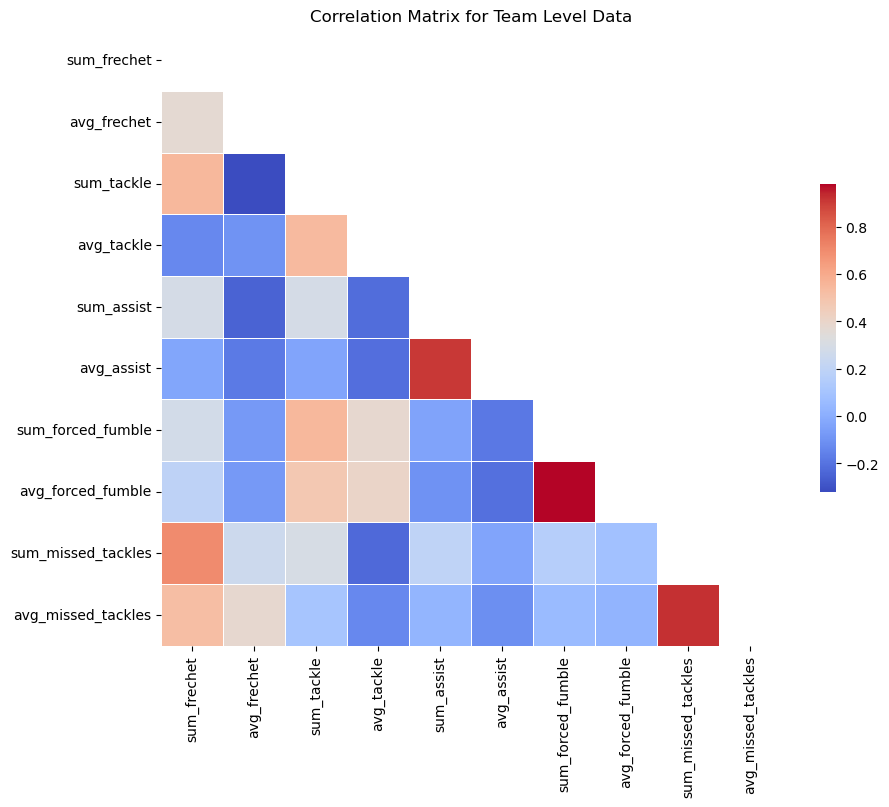

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
corr_matrix_team = team_level_agg.select_dtypes(include=[np.number]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix_team, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_team, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix for Team Level Data')
plt.show()


In [192]:
# Aggregate at the player level
player_level_agg = merged_df.groupby(['nflId', 'displayName']).agg(
    sum_frechet=('frechet_distance', 'sum'),
    avg_frechet=('frechet_distance', 'mean'),
    min_frechet=('frechet_distance', 'min'),
    max_frechet=('frechet_distance', 'max'),
    sum_tackle=('tackle', 'sum'),
    avg_tackle=('tackle', 'mean'),
    min_tackle=('tackle', 'min'),
    max_tackle=('tackle', 'max'),
    # Repeat for assist, forcedFumble, and pff_missedTackle
    sum_assist=('assist', 'sum'),
    avg_assist=('assist', 'mean'),
    min_assist=('assist', 'min'),
    max_assist=('assist', 'max'),
    sum_forced_fumble=('forcedFumble', 'sum'),
    avg_forced_fumble=('forcedFumble', 'mean'),
    min_forced_fumble=('forcedFumble', 'min'),
    max_forced_fumble=('forcedFumble', 'max'),
    sum_missed_tackles=('pff_missedTackle', 'sum'),
    avg_missed_tackles=('pff_missedTackle', 'mean'),
    min_missed_tackles=('pff_missedTackle', 'min'),
    max_missed_tackles=('pff_missedTackle', 'max'),
).reset_index()


In [193]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate mean Fréchet distance, play count, and get the team at the player level
player_stats = df.groupby(['displayName', 'defensiveTeam', 'position'])['frechet_distance'].agg(['mean', 'count']).reset_index()

# Filter out players with fewer than 10 plays
player_stats_filtered = player_stats[player_stats['count'] >= 100]

# Get unique positions
positions = df['position'].unique()

# Loop through each position to create a separate ridge plot
for position in positions:
    # Filter the DataFrame for the current position
    df_position = df[df['position'] == position]

    # Find top players for the current position based on mean Fréchet distance
    top_players = player_stats_filtered[player_stats_filtered['position'] == position].sort_values(by='mean', ascending=True).head(10)
    
    # Create a label combining player's name and team
    top_players['label'] = top_players[['displayName', 'defensiveTeam']].agg(' - '.join, axis=1)

    # Merge the top players' labels back onto the position DataFrame
    df_position = df_position.merge(top_players[['displayName', 'label']], on='displayName', how='left')
    
    # Initialize the FacetGrid object
    g = sns.FacetGrid(df_position, row='label', hue='label', aspect=15, height=.5, palette="muted", row_order=top_players['label'].tolist())
    
    # Map the kdeplot onto the grid
    g.map(sns.kdeplot, 'frechet_distance', clip_on=True, fill=True, common_norm=False, bw_adjust=1, cut=0)

    # Remove 'Density' label and set player names as y-axis labels
    for ax, label in zip(g.axes.flatten(), top_players['label']):
        ax.set_ylabel(label, rotation=0, fontsize=10, labelpad=10)
        ax.yaxis.label.set_horizontalalignment('right')
    
    # Overlap the rows of the grid
    g.fig.subplots_adjust(hspace=-0.3)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.set_xlabels('Fréchet Distance')
    g.despine(bottom=True, left=True)
    # Add a title to the figure
    plt.subplots_adjust(top=0.92)
    g.fig.suptitle(f'Week 1-8 {position} - Player Mean Fréchet Distance Rankings (Min 20 Plays)', fontsize=16)
    
    # Save the figure for each position
    plt.savefig(f'player_fechet_ridgeplot_week1_{position}.png')
    
    # Show the plot
    plt.show()


ValueError: Cannot set a DataFrame with multiple columns to the single column label

In [ ]:
# Calculate sum of Fréchet distance per play at the team level
team_play_distance = df.groupby(['defensiveTeam', 'playId'])['frechet_distance'].sum().reset_index()

# Calculate mean Fréchet distance per play for each team
team_stats = team_play_distance.groupby('defensiveTeam')['frechet_distance'].agg(['mean', 'count']).reset_index()

# Filter out teams with fewer than a certain threshold of plays
min_plays_threshold = 10  # Define a threshold for minimum number of plays
team_stats_filtered = team_stats[team_stats['count'] >= min_plays_threshold]

# Rank the teams by average Fréchet distance
team_stats_filtered = team_stats_filtered.sort_values(by='mean', ascending=True)

# Select top N teams for visualization
top_teams = team_stats_filtered.head(32)  # Adjust N here as needed

# Merge the top teams' data back onto the original team_play_distance DataFrame
team_play_distance = team_play_distance.merge(top_teams[['defensiveTeam']], on='defensiveTeam', how='inner')

# Initialize the FacetGrid object with teams
g = sns.FacetGrid(team_play_distance, row='defensiveTeam', hue='defensiveTeam', aspect=15, height=.5, palette="muted")

# Map the kdeplot onto the grid
g.map(sns.kdeplot, 'frechet_distance', clip_on=False, fill=True, common_norm=False, bw_adjust=0.5)

# Remove 'Density' label and set team names as y-axis labels
for ax, label in zip(g.axes.flatten(), top_teams['defensiveTeam']):
    ax.set_ylabel(label, rotation=0, fontsize=10, labelpad=10)
    ax.yaxis.label.set_horizontalalignment('right')

# Overlap the rows of the grid
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.set_xlabels('Summed Fréchet Distance per Play')
g.despine(bottom=True, left=True)

# Add a title to the figure
plt.subplots_adjust(top=0.92)
g.fig.suptitle(f'Week 1 -4 Team Secondary (FS, SS, CB) Mean Fréchet Distance Rankings (Min {min_plays_threshold} Plays)', fontsize=16)
plt.savefig(f'team_secondary_rankings.png')

# Show the plot
plt.show()


In [ ]:
# Assuming df is your primary DataFrame and additional_data contains 'yardsToGo' and 'playResult'
playfrechet_df = df.merge(plays_data[['gameId', 'playId', 'yardsToGo', 'prePenaltyPlayResult','preSnapVisitorScore','preSnapHomeScore','gameClock']], on=['gameId', 'playId'], how='left')


In [ ]:
# Summing Fréchet distance for each play
play_level_frechet = playfrechet_df.groupby(['game_id', 'play_id', 'defensiveTeam']).agg(
    play_frechet=('frechet_distance', 'sum'),
    prePenaltyPlayResult=('prePenaltyPlayResult', 'first')

).reset_index()

# Aggregate data at the team level
team_agg = play_level_frechet.groupby('defensiveTeam').agg(
   avg_frechet_per_play=('play_frechet', 'sum'),
    avg_play_result_per_play=('prePenaltyPlayResult', 'sum'),
).reset_index()


In [ ]:
# Merge the aggregated data with the team colors data
final_data = team_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import linregress

# Calculate R² value
slope, intercept, r_value, p_value, std_err = linregress(final_data['avg_frechet_per_play'], final_data['avg_play_result_per_play'])

# Create the scatter plot with a regression line
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(x='avg_frechet_per_play', y='avg_play_result_per_play', data=final_data, ax=ax, scatter=False, color='red')

# Invert X and Y axes
ax.invert_xaxis()
ax.invert_yaxis()

# Plot each team with its logo
for index, row in final_data.iterrows():
    # Load team logo from URL
    response = requests.get(row['team_logo_espn'])
    img = Image.open(BytesIO(response.content))

    # Convert image to a format suitable for matplotlib
    imagebox = OffsetImage(img, zoom=0.08)
    ab = AnnotationBbox(imagebox, (row['avg_frechet_per_play'], row['avg_play_result_per_play']), frameon=False)
    ax.add_artist(ab)

# Adjust the quadrant labels according to the inverted axes
ax.text(0.05, 0.05, 'More Yards Allowed\nHigher Deviation from Swarm Path', ha='left', va='top', transform=ax.transAxes, fontsize=12)
ax.text(0.95, 0.05, 'More Yards Allowed\nLower Deviation from Swarm Path', ha='right', va='top', transform=ax.transAxes, fontsize=12)
ax.text(0.05, 0.95, 'Fewer Yards Allowed\nHigher Deviation from Swarm Path', ha='left', va='bottom', transform=ax.transAxes, fontsize=12)
ax.text(0.95, 0.95, 'Fewer Yards Allowed\nLower Deviation from Swarm Path', ha='right', va='bottom', transform=ax.transAxes, fontsize=12)

# Ensure labels are within plot area by setting margins or adjusting axes limits if necessary
ax.margins(x=0.1, y=0.1)  # Add 10% margin on both axes to prevent clipping of labels


# Set labels and title
ax.set_xlabel('Yards from Optimal Path')
ax.set_ylabel('Total Yards Allowed')
ax.set_title('Correlation between Yards from Optimal Path and Total Yards Allowed n\
(Weeks 1, 2022) by Defensive Team Secondary')
ax.text(0.5, 0.95, f'R\u00b2 = {r_value**2:.2f}', ha='right', va='top', transform=ax.transAxes, color='red', fontsize=12)

plt.show()





In [130]:
# Merging the Frechet data with game results
merged_df = playfrechet_df.merge(games_data, left_on='gameId', right_on='gameId')

# Determine if the defensive team is home or away
merged_df['is_defensive_team_home'] = merged_df['defensiveTeam'] == merged_df['homeTeamAbbr']


In [131]:
# Calculate score differential
merged_df['score_differential'] = np.where(
    merged_df['is_defensive_team_home'],
    merged_df['preSnapHomeScore'] - merged_df['preSnapVisitorScore'],
    merged_df['preSnapVisitorScore'] - merged_df['preSnapHomeScore']
)

In [132]:
# Summing Fréchet distance for each play
play_level_frechet = merged_df.groupby(['game_id', 'play_id', 'defensiveTeam','gameClock','passResult','yardsToGo','prePenaltyPlayResult']).agg(
    play_frechet=('frechet_distance', 'sum'),
    score_differential=('score_differential', 'first')

).reset_index()


In [133]:
# Function to convert game clock to a numerical value (minutes)
def convert_game_clock(clock_str):
    minutes, seconds = map(int, clock_str.split(':'))
    return minutes + seconds / 60.0

# Apply the conversion function to the gameClock column
play_level_frechet['gameClockMinutes'] = play_level_frechet['gameClock'].apply(convert_game_clock)


In [134]:
play_level_frechet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game_id               637 non-null    int64  
 1   play_id               637 non-null    int64  
 2   defensiveTeam         637 non-null    object 
 3   gameClock             637 non-null    object 
 4   passResult            637 non-null    object 
 5   yardsToGo             637 non-null    int64  
 6   prePenaltyPlayResult  637 non-null    int64  
 7   play_frechet          637 non-null    float64
 8   score_differential    637 non-null    int64  
 9   gameClockMinutes      637 non-null    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 49.9+ KB


In [135]:
# Corrected aggregation at the team level for each game
game_level_frechet = play_level_frechet.groupby(['defensiveTeam', 'game_id']).agg(
    total_frechet_per_game=('play_frechet', 'sum'),
    total_score_differential_per_game=('score_differential', 'first')
).reset_index()

# Corrected aggregation at the team level for each game
team_agg = game_level_frechet.groupby(['defensiveTeam']).agg(
    total_frechet=('total_frechet_per_game', 'sum'),
    total_score_differential=('total_score_differential_per_game', 'sum')
).reset_index()


In [136]:
team_agg

,defensiveTeam,total_frechet,total_score_differential
0,ARI,935.786718,0
1,ATL,488.624816,3
2,BAL,1301.703744,0
3,BUF,871.790670,7
4,CAR,465.092199,0
5,CHI,460.515607,0
6,CIN,685.488037,0
7,CLE,983.354015,0
8,DAL,599.013296,3
9,DEN,742.018680,0


In [137]:
# Calculate correlation
correlation = team_agg['total_frechet'].corr(team_agg['total_score_differential'])

# Output correlation
print("Correlation between total Frechet distance and total score differential:", correlation)


Correlation between total Frechet distance and total score differential: 0.2818678316171935


In [138]:
final_data = team_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')

In [139]:
# Assuming 'merged_df' is your dataframe and 'prePenaltyPlayResult' is your target yards
play_level_frechet['is_explosive'] = ((play_level_frechet['passResult'] == 'C') & (play_level_frechet['prePenaltyPlayResult'] >= 10)) | \
                            ((play_level_frechet['passResult'] == 'R') & (play_level_frechet['prePenaltyPlayResult'] >= 20))

In [140]:
play_level_frechet.columns

Index(['game_id', 'play_id', 'defensiveTeam', 'gameClock', 'passResult',
       'yardsToGo', 'prePenaltyPlayResult', 'play_frechet',
       'score_differential', 'gameClockMinutes', 'is_explosive'],
      dtype='object')

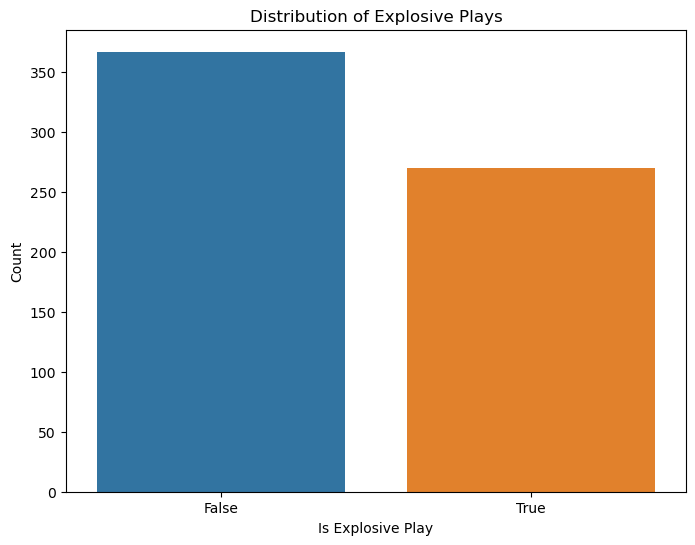

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a countplot for the "is_explosive" variable
plt.figure(figsize=(8, 6))
sns.countplot(data=play_level_frechet, x='is_explosive')
plt.xlabel('Is Explosive Play')
plt.ylabel('Count')
plt.title('Distribution of Explosive Plays')
plt.show()


In [142]:
import nfl_data_py as nfl


In [143]:
# Define the years and columns of interest
years = [2022]
columns = ['old_game_id', 'play_id', 'yards_after_catch', 
           'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 
           'comp_yac_epa', 'comp_yac_wpa', 'week']

# Import the play-by-play data
pbp_data = nfl.import_pbp_data(years, columns)

# Filter for weeks 1-9
filtered_pbp_data = pbp_data[pbp_data['week'].between(1, 9)]

# Ensure the data types for merging columns are consistent
filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)
play_level_frechet['game_id'] = play_level_frechet['game_id'].astype(int)

# Import the play_level_frechet data
# You would need to specify how to import this data, as the method is not provided in your query

# Merge the data
data = pd.merge(filtered_pbp_data, play_level_frechet, left_on=['old_game_id', 'play_id'], right_on=['game_id', 'play_id'])


2022 done.
Downcasting floats.


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_9116/1363353254.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)


In [144]:
import pandas as pd

# Assuming 'data' is your DataFrame
# Count the occurrences of each play_id
play_id_counts = data['play_id'].value_counts()

# Identify the play_ids that occur more than once
duplicate_play_ids = play_id_counts[play_id_counts > 1]

# Number of unique play_ids that have duplicates
num_duplicate_play_ids = len(duplicate_play_ids)

# Total number of duplicate entries
total_duplicates = duplicate_play_ids.sum()

print(f"Number of unique play_ids with duplicates: {num_duplicate_play_ids}")
print(f"Total number of duplicate play_id entries: {total_duplicates}")


Number of unique play_ids with duplicates: 37
Total number of duplicate play_id entries: 75


In [145]:
data.columns

Index(['old_game_id', 'play_id', 'yards_after_catch', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'comp_yac_epa',
       'comp_yac_wpa', 'week', 'season', 'nflverse_game_id', 'possession_team',
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'players_on_play',
       'offense_players', 'defense_players', 'n_offense', 'n_defense',
       'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route',
       'defense_man_zone_type', 'defense_coverage_type', 'game_id',
       'defensiveTeam', 'gameClock', 'passResult', 'yardsToGo',
       'prePenaltyPlayResult', 'play_frechet', 'score_differential',
       'gameClockMinutes', 'is_explosive'],
      dtype='object')

In [146]:
# Define the years and columns of interest
years = [2022]
columns = ['nflverse_play_id', 'is_screen_pass', 
           'is_play_action', 'is_contested_ball', 'week']


# Import the FTN data
ftn_data = nfl.import_ftn_data(years, columns)
ftn_data.columns
# Filter for weeks 1-9
filtered_ftn_data = ftn_data[ftn_data['week'].between(1, 9)]

# Ensure the data types for merging columns are consistent
filtered_ftn_data['week'] = filtered_ftn_data['week'].astype(int)
filtered_ftn_data['nflverse_play_id'] = filtered_ftn_data['nflverse_play_id'].astype(int)


data['week'] = data['week'].astype(int)
data['play_id'] = data['play_id'].astype(int)

# Merge the data on 'week' and 'nflverse_play_id' with a left join
merged_data = pd.merge(data, filtered_ftn_data,
                       left_on=['week', 'play_id'], 
                       right_on=['week', 'nflverse_play_id'],
                       how='left')



Downcasting floats.


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_9116/790701669.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ftn_data['week'] = filtered_ftn_data['week'].astype(int)
/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_9116/790701669.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ftn_data['nflverse_play_id'] = filtered_ftn_data['nflverse_play_id'].astype(int)


In [151]:
# Step 1: Filter the data for completed passes
# Filter for completed passes where is_screen_pass is True
completed_passes = merged_data[(merged_data['passResult'] == 'C')]


Correlation between YAC difference and Frechet distance: 0.593


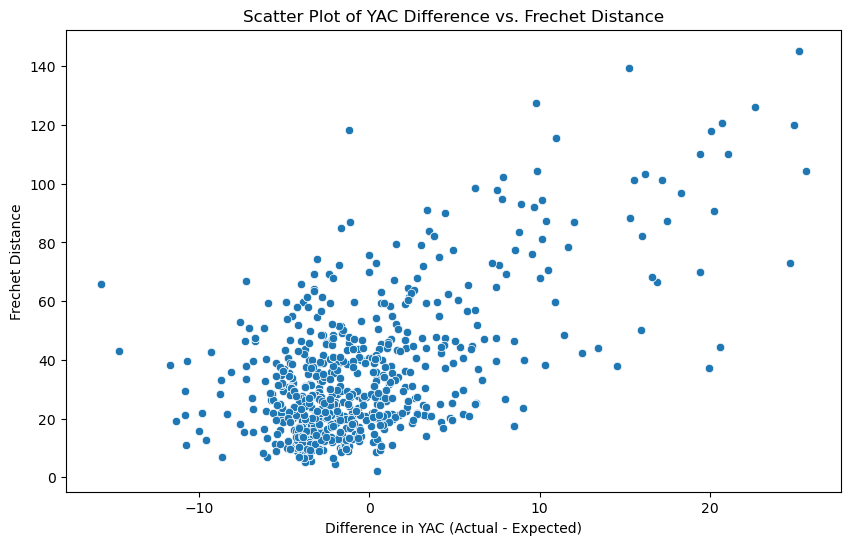

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_data' is your merged dataset



# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
completed_passes['yac_diff'] = completed_passes['yards_after_catch'] - completed_passes['xyac_mean_yardage']

# Step 3: Assess the correlation
correlation = completed_passes[['yac_diff', 'play_frechet']].corr().iloc[0, 1]
print(f"Correlation between YAC difference and Frechet distance: {correlation:.3f}")

# Step 4: Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=completed_passes, x='yac_diff', y='play_frechet')
plt.title('Scatter Plot of YAC Difference vs. Frechet Distance')
plt.xlabel('Difference in YAC (Actual - Expected)')
plt.ylabel('Frechet Distance')
plt.show()



Correlation in low unexpected YAC subset: 0.129


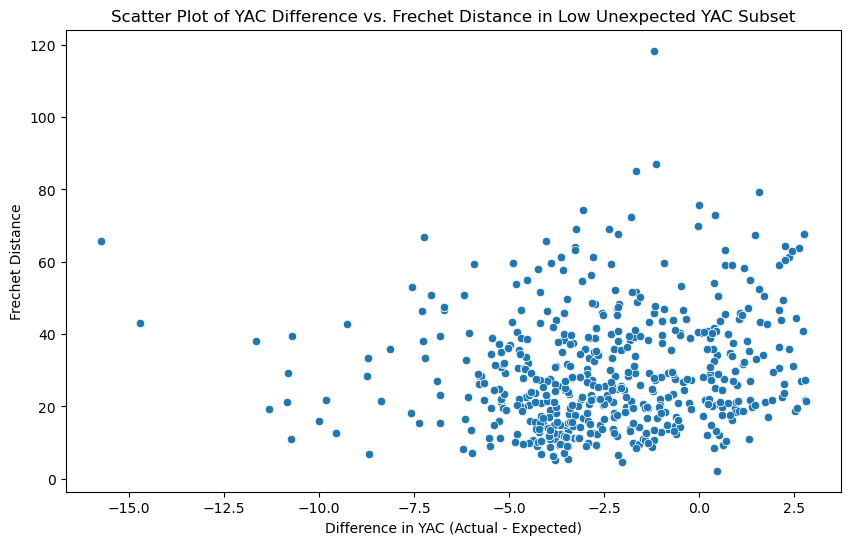

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_data' is your merged dataset

# Step 1: Filter for completed passes
completed_passes = merged_data[merged_data['passResult'] == 'C']

# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
completed_passes['yac_diff'] = completed_passes['yards_after_catch'] - completed_passes['xyac_mean_yardage']

# Step 3: Define a threshold for low unexpected YAC and filter
# Let's say we define "significantly lower" as at least 3 yards less than expected
threshold = 3
low_unexpected_yac = completed_passes[completed_passes['yac_diff'] <= threshold]

# Step 4: Assess the correlation in this subset
correlation = low_unexpected_yac[['yac_diff', 'play_frechet']].corr().iloc[0, 1]
print(f"Correlation in low unexpected YAC subset: {correlation:.3f}")

# Step 5: Create a scatter plot for this subset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=low_unexpected_yac, x='yac_diff', y='play_frechet')
plt.title('Scatter Plot of YAC Difference vs. Frechet Distance in Low Unexpected YAC Subset')
plt.xlabel('Difference in YAC (Actual - Expected)')
plt.ylabel('Frechet Distance')
plt.show()


In [195]:
merged_data.columns

Index(['old_game_id', 'play_id', 'yards_after_catch', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'comp_yac_epa',
       'comp_yac_wpa', 'week', 'season', 'nflverse_game_id', 'possession_team',
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'players_on_play',
       'offense_players', 'defense_players', 'n_offense', 'n_defense',
       'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route',
       'defense_man_zone_type', 'defense_coverage_type', 'game_id',
       'defensiveTeam', 'gameClock', 'passResult', 'yardsToGo',
       'prePenaltyPlayResult', 'play_frechet', 'score_differential',
       'gameClockMinutes', 'is_explosive', 'nflverse_play_id',
       'is_screen_pass', 'is_play_action', 'is_contested_ball'],
      dtype='object')

In [197]:
merged_data
# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
merged_data['yac_diff'] = merged_data['yards_after_catch'] - merged_data['xyac_mean_yardage']

In [198]:
# Define the conditions
conditions = ['is_screen_pass', 'is_contested_ball', 'is_play_action', 'yac_diff']

# Initialize a dictionary to store the results
results = {}

for condition in conditions:
    if condition != 'yac_diff':
        # Filter based on the condition
        filtered_df = merged_data[merged_data[condition] == True]
    else:
        # Use the entire DataFrame for yac_diff condition
        filtered_df = merged_data

    # Ensure the DataFrame is not empty
    if not filtered_df.empty:
        # Sort and find the plays with the highest and lowest frechet distances
        highest_frechet = filtered_df.sort_values(by='play_frechet', ascending=False).head(1)
        lowest_frechet = filtered_df.sort_values(by='play_frechet', ascending=True).head(1)

        results[condition] = {
            'highest_frechet': highest_frechet[['week', 'game_id', 'play_id', 'play_frechet']],
            'lowest_frechet': lowest_frechet[['week', 'game_id', 'play_id', 'play_frechet']]
        }

        # For yac_diff condition, also find the highest and lowest yac_diff
        if condition == 'yac_diff':
            top_yac_diff = filtered_df.sort_values(by='yac_diff', ascending=False).head(1)
            lowest_yac_diff = filtered_df.sort_values(by='yac_diff', ascending=True).head(1)

            results[condition].update({
                'top_yac_diff': top_yac_diff[['week', 'game_id', 'play_id', 'yac_diff']],
                'lowest_yac_diff': lowest_yac_diff[['week', 'game_id', 'play_id', 'yac_diff']]
            })

# Print the results
for condition, data in results.items():
    print(f"Condition: {condition}")
    print("Highest Frechet:\n", data['highest_frechet'])
    print("Lowest Frechet:\n", data['lowest_frechet'])
    if condition == 'yac_diff':
        print("Top YAC Diff:\n", data['top_yac_diff'])
        print("Lowest YAC Diff:\n", data['lowest_yac_diff'])
    print("\n")

Condition: is_screen_pass
Highest Frechet:
      week     game_id  play_id  play_frechet
830     1  2022091103     1126    145.306548
Lowest Frechet:
      week     game_id  play_id  play_frechet
761     1  2022091104      580      6.896992


Condition: is_contested_ball
Highest Frechet:
      week     game_id  play_id  play_frechet
544     1  2022091111     1946      98.44436
Lowest Frechet:
      week     game_id  play_id  play_frechet
215     1  2022091200      156      5.584881


Condition: is_play_action
Highest Frechet:
      week     game_id  play_id  play_frechet
830     1  2022091103     1126    145.306548
Lowest Frechet:
      week     game_id  play_id  play_frechet
832     1  2022091103     1249      2.220136


Condition: yac_diff
Highest Frechet:
      week     game_id  play_id  play_frechet
830     1  2022091103     1126    145.306548
Lowest Frechet:
      week     game_id  play_id  play_frechet
832     1  2022091103     1249      2.220136
Top YAC Diff:
      week     game

In [199]:
test_df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/specific_plays_paths.csv')

In [203]:
# Assuming test_df is your DataFrame
print("Number of unique NFL IDs:", test_df['nflId'].nunique())
print("Number of unique Play IDs:", test_df['playId'].nunique())
print("Number of unique Games:", test_df['gameId'].nunique())


Number of unique NFL IDs: 29
Number of unique Play IDs: 7
Number of unique Games: 6


In [204]:
# Group by 'playId' and count unique 'nflId's in each group
unique_nfl_ids_per_play = test_df.groupby('playId')['nflId'].nunique()

# Calculate the average number of unique 'nflId's per play
average_nfl_ids_per_play = unique_nfl_ids_per_play.mean()

print("Average number of unique NFL IDs per play:", average_nfl_ids_per_play)


Average number of unique NFL IDs per play: 4.285714285714286


In [206]:
# Group by 'playId' and count unique 'frameId's in each group
unique_frames_per_play = test_df.groupby('playId')['frameId'].nunique()

# Calculate the average number of unique frames per play
average_frames_per_play = unique_frames_per_play.mean()

print("Average number of unique frames per play:", average_frames_per_play)



Average number of unique frames per play: 28.714285714285715


In [207]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nflId     1259 non-null   float64
 1   gameId    1259 non-null   int64  
 2   playId    1259 non-null   int64  
 3   frameId   1259 non-null   int64  
 4   actual_x  1259 non-null   float64
 5   actual_y  1259 non-null   float64
 6   smooth_x  1259 non-null   float64
 7   smooth_y  1259 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 78.8 KB
